<a href="https://colab.research.google.com/github/whispermy/novatus_academia/blob/main/Week4_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**AI 노바투스과정**

Week 4: 딥러닝 기초 II (2021-08-27)

실습 #2: 순환 신경망 학습 실습하기

In [ ]:
### 필요 패키지 불러오기

import numpy as np
import tensorflow.keras as keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
### 그래프 그리는 함수 만들기

def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
  n_steps = series.shape[0]
  plt.plot(series, ".-", label='x')
  if y is not None:
    plt.plot(n_steps, y, "bx", label='actual y', markersize=10)
  if y_pred is not None:
    plt.plot(n_steps, y_pred, "ro", label="predicted y")
  plt.grid(True)
  if x_label:
    plt.xlabel(x_label, fontsize=16)
  if y_label:
    plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.hlines(0, 0, 100, linewidth=1)
  plt.axis([0, n_steps + 1, None, None])
  plt.legend()

def plot_multiple_forecasts(X, Y, Y_pred):
  n_steps = X.shape[1]
  ahead = Y.shape[1]
  plot_series(X[0, :, 0])
  plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-",label="Actual")
  plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-",label="Forecast", markersize=10)
  plt.axis([0, n_steps + ahead, None, None])
  plt.legend(fontsize=14)

## 0. 시계열 데이터셋 준비

In [ ]:
### 시뮬레이션 데이터셋 생성을 위한 함수 만들기

import numpy as np

def generate_time_series(batch_size, n_steps):
  freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
  time = np.linspace(0, 1, n_steps)
  series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) # wave 1
  series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
  series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # + noise
  return series[..., np.newaxis].astype(np.float32) # same as series[:, :, np.newaxis].astype(np.float32)


In [ ]:
# 데이터셋 만들기

n_steps = 50
series = generate_time_series(10000, n_steps + 1)


In [ ]:
# train, validation, test set 으로 분리하기

X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]


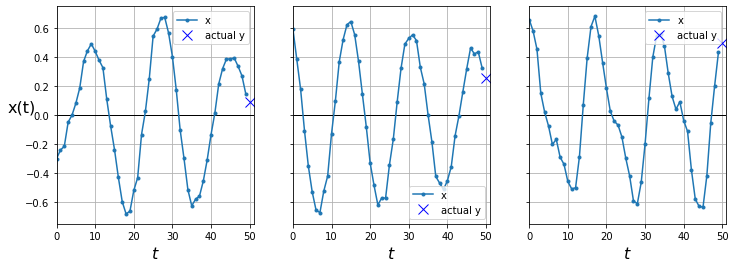

In [ ]:
# plot_series() 함수로 데이터 살펴보기

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
  plt.sca(axes[col])
  plot_series(X_train[col, :, :], y_train[col, :], y_label=("x(t)" if col==0 else None))
plt.show()

## 1. 완전 접속 신경망 구현하기

In [ ]:
# gpu 설정
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:

model=keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[50,1]))
model.add(keras.layers.Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

history=model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 4s 4ms/step - loss: 0.0816 - val_loss: 0.0284
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0173 - val_loss: 0.0108
Epoch 3/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0084 - val_loss: 0.0076
Epoch 4/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0067 - val_loss: 0.0068
Epoch 5/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0062 - val_loss: 0.0064
Epoch 6/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0059 - val_loss: 0.0062
Epoch 7/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0057 - val_loss: 0.0058
Epoch 8/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 9/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0053 - val_loss: 0.0054
Epoch 10/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0051 - val_loss: 0.0052

In [ ]:
# 학습 결과 확인하기

model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 2ms/step - loss: 0.0035


0.0034652352333068848

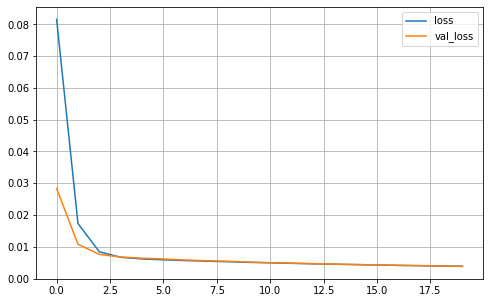

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)

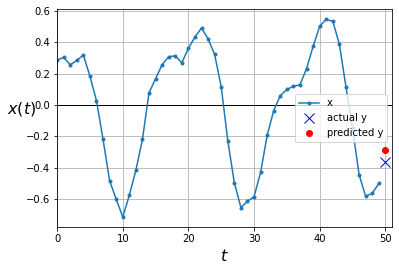

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, :], y=y_valid[0, :], y_pred=y_pred[0, :])
plt.show()

## 2. 단층 RNN 구현하기

In [ ]:
# RNN 모형의 골격 만들기

with tf.device('/device:GPU:0'):
  model = keras.models.Sequential()
  model.add(keras.layers.SimpleRNN(1, input_shape = [None, 1]))


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#모형 컴파일 하기
# mse = mean square error
model.compile(loss='mse', optimizer='adam')

In [ ]:
# 모형 학습하기

history=model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
219/219 [==============================] - 17s 76ms/step - loss: 0.1860 - val_loss: 0.1224
Epoch 2/10
219/219 [==============================] - 17s 76ms/step - loss: 0.0902 - val_loss: 0.0736
Epoch 3/10
219/219 [==============================] - 16s 75ms/step - loss: 0.0653 - val_loss: 0.0600
Epoch 4/10
219/219 [==============================] - 16s 75ms/step - loss: 0.0550 - val_loss: 0.0514
Epoch 5/10
219/219 [==============================] - 16s 73ms/step - loss: 0.0474 - val_loss: 0.0446
Epoch 6/10
219/219 [==============================] - 16s 74ms/step - loss: 0.0415 - val_loss: 0.0393
Epoch 7/10
219/219 [==============================] - 16s 74ms/step - loss: 0.0369 - val_loss: 0.0351
Epoch 8/10
219/219 [==============================] - 16s 73ms/step - loss: 0.0331 - val_loss: 0.0317
Epoch 9/10
219/219 [==============================] - 16s 75ms/step - loss: 0.0300 - val_loss: 0.0287
Epoch 10/10
219/219 [==============================] - 16s 73ms/step - loss: 0.027

In [ ]:
# 학습 결과 확인하기

model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 12ms/step - loss: 0.0270


0.026964547112584114

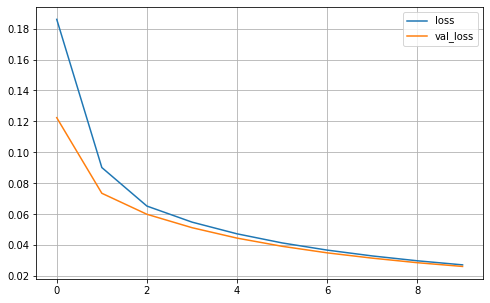

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)

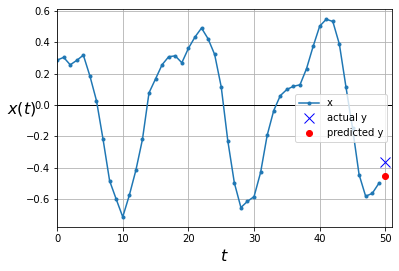

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, :], y_valid[0, :], y_pred[0, :])
plt.show()

## 3. 다층 RNN 구현하기

In [ ]:
# RNN 모형의 골격 만들기


with tf.device('/device:GPU:0'):
  model = keras.models.Sequential()
  model.add(keras.layers.SimpleRNN(20, return_sequences=True, input_shape = [None, 1]))
  model.add(keras.layers.SimpleRNN(20, return_sequences=True))
  model.add(keras.layers.SimpleRNN(1))


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 20)          820       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 1)                 22        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 모형 컴파일 하기

model.compile(loss='mse', optimizer='adam')

In [ ]:
# 모형 학습하기

history=model.fit(X_train, y_train, epochs=3, validation_data=(X_valid, y_valid))


Epoch 1/3
219/219 [==============================] - 61s 269ms/step - loss: 0.0370 - val_loss: 0.0098
Epoch 2/3
219/219 [==============================] - 59s 267ms/step - loss: 0.0063 - val_loss: 0.0051
Epoch 3/3
219/219 [==============================] - 58s 263ms/step - loss: 0.0047 - val_loss: 0.0040


In [ ]:
# 학습결과 확인하기

model.evaluate(X_test, y_test)

32/32 [==============================] - 1s 35ms/step - loss: 0.0039


0.003874806221574545

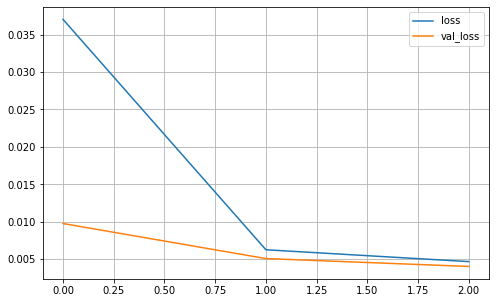

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)

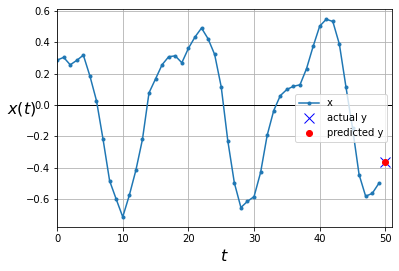

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, :], y_valid[0, :], y_pred[0, :])
plt.show()

## 3. 다층 RNN 구현하기 2

In [ ]:
# RNN 모형의 골격 만들기

with tf.device('/device:GPU:0'):
  model = keras.models.Sequential()
  model.add(keras.layers.SimpleRNN(20, return_sequences=True, input_shape = [None, 1]))
  model.add(keras.layers.SimpleRNN(20))
  model.add(keras.layers.Dense(1))


In [ ]:
# 모형 컴파일 하기

model.compile(loss='mse', optimizer='adam')

In [ ]:
# 모형 학습하기

history=model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))


Epoch 1/5
219/219 [==============================] - 38s 167ms/step - loss: 0.0150 - val_loss: 0.0046
Epoch 2/5
219/219 [==============================] - 36s 165ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 3/5
219/219 [==============================] - 36s 166ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 4/5
219/219 [==============================] - 36s 166ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 5/5
219/219 [==============================] - 36s 166ms/step - loss: 0.0032 - val_loss: 0.0031


In [ ]:
# 학습결과 확인하기

model.evaluate(X_test, y_test)

32/32 [==============================] - 1s 24ms/step - loss: 0.0030


0.0029824059456586838

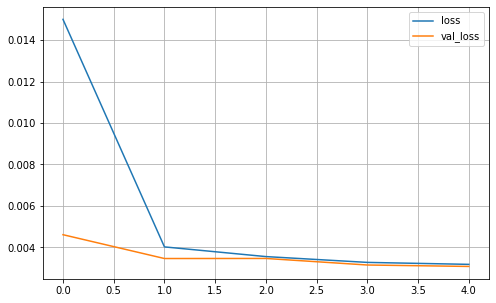

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)

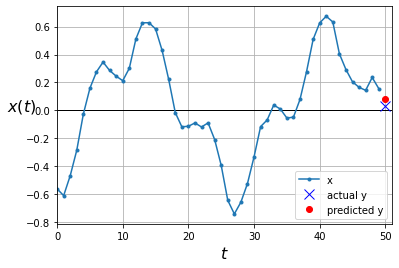

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[1, :, :], y_valid[1, :], y_pred[1, :])
plt.show()

## 4. 순환 신경망 모형 이용하여 multi-step forecasting 하기

### 4.1 앞의 모형을 이용하여 one-step forcasting 으로 다음값을 예측한 후, 이를 다시 입력값으로 사용하는 방법

In [ ]:
#테스트용 데이터 하나 생성하기

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new

#학습한 모형을 이용하여 테스트용 데이터의 향후 10 스텝 예측하기

for step_ahead in range(10):
  y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
  X = np.concatenate([X, y_pred_one], axis=1)
Y_pred = X[:, n_steps:]


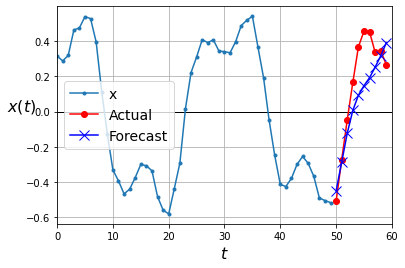

In [ ]:
# 예측 결과와 실제 값 비교하기

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# epoch의 횟수가 작아서 오차가 많이 날 수 있다. 최소 10회 이상 해야 제대로 된 결과를 볼 수 있다.


### 4.2 multi-step 을 한번에 예측하는 모형을 이용하는 방법

In [ ]:
# 데이터셋 준비 (multi-step 예측이 가능한 모형을 학습하기 위해 "적절한" 학습용 데이터를 먼저 구축해야 함. )
# X 는 그대로 사용하되, target Y 를 변경해야 함.

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [ ]:
# RNN 모형의 골격 만들기

with tf.device('/device:GPU:0'):
  model = keras.models.Sequential()
  model.add(keras.layers.SimpleRNN(20, return_sequences=True, input_shape = [None, 1]))
  model.add(keras.layers.SimpleRNN(20))
  model.add(keras.layers.Dense(10))



In [ ]:
# 모형 컴파일 및 학습하기 

model.compile(loss='mse', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=5, validation_data=(X_valid, Y_valid))


Epoch 1/5
219/219 [==============================] - 38s 168ms/step - loss: 0.0645 - val_loss: 0.0280
Epoch 2/5
219/219 [==============================] - 37s 168ms/step - loss: 0.0247 - val_loss: 0.0233
Epoch 3/5
219/219 [==============================] - 37s 169ms/step - loss: 0.0195 - val_loss: 0.0189
Epoch 4/5
219/219 [==============================] - 36s 167ms/step - loss: 0.0162 - val_loss: 0.0166
Epoch 5/5
219/219 [==============================] - 37s 170ms/step - loss: 0.0141 - val_loss: 0.0132


In [ ]:
# 학습 결과 확인하기

model.evaluate(X_test, Y_test)

32/32 [==============================] - 1s 25ms/step - loss: 0.0140


0.013983958400785923

In [ ]:
#테스트용 데이터 하나 생성하기

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new

#학습한 모형을 이용하여 테스트용 데이터의 향후 10 스텝 예측하기

Y_pred=model.predict(X_new)[..., np.newaxis]

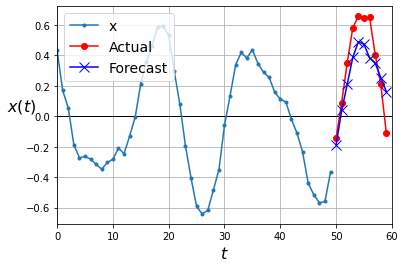

In [ ]:
# 예측 결과와 실제 값 비교하기

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()


### 4.3 각 시점마다 multi-step 을 예측하는 모형 구현하기

In [ ]:
# 데이터셋 준비 (각 시점마다 multi-step 예측이 가능한 모형을 학습하기 위해 "적절한" 학습용 데이터를 먼저 구축해야 함. )
# X 는 그대로 사용하되, target Y 를 변경해야 함.

Y = np.empty((10000, n_steps, 10)) 
for step_ahead in range(1, 10 + 1):
  Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]



In [ ]:
# RNN 모형의 골격 만들기
### TimeDistributed layer 의 사용 

with tf.device('/device:GPU:0'):
  model = keras.models.Sequential()
  model.add(keras.layers.SimpleRNN(20, return_sequences=True, input_shape = [None, 1]))
  model.add(keras.layers.SimpleRNN(20, return_sequences=True))
  model.add(keras.layers.TimeDistributed(keras.layers.Dense(10)))



In [ ]:
# 모형 컴파일 및 학습하기

def last_time_step_mse(Y_true, Y_pred):
  return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])

history = model.fit(X_train, Y_train, epochs=5, validation_data=(X_valid, Y_valid))

Epoch 1/5
219/219 [==============================] - 40s 174ms/step - loss: 0.1245 - last_time_step_mse: 0.1685 - val_loss: 0.0297 - val_last_time_step_mse: 0.0328
Epoch 2/5
219/219 [==============================] - 38s 171ms/step - loss: 0.0089 - last_time_step_mse: 0.0105 - val_loss: 0.0056 - val_last_time_step_mse: 0.0066
Epoch 3/5
219/219 [==============================] - 38s 173ms/step - loss: 0.0042 - last_time_step_mse: 0.0036 - val_loss: 0.0028 - val_last_time_step_mse: 0.0019
Epoch 4/5
219/219 [==============================] - 38s 176ms/step - loss: 0.0020 - last_time_step_mse: 0.0017 - val_loss: 0.0014 - val_last_time_step_mse: 0.0013
Epoch 5/5
219/219 [==============================] - 39s 177ms/step - loss: 0.0012 - last_time_step_mse: 0.0011 - val_loss: 0.0010 - val_last_time_step_mse: 0.0013


In [ ]:
# 학습결과 확인하기

model.evaluate (X_test, Y_test)

32/32 [==============================] - 1s 25ms/step - loss: 0.0010 - last_time_step_mse: 0.0013


[0.0010228941682726145, 0.0012674388708546758]

## 5. 깊은 순환 신경망 모형 학습하기

### 5.1 Layer Normalization (RNN 의 정규화 방법) 구현하기

In [ ]:
# Layer Normalization 을 적용한 memory cell 만들기

class LNSimpleRNNCell(keras.layers.Layer):
  def __init__(self, units, activation="tanh", **kwargs):
    super().__init__(**kwargs)
    self.state_size = units
    self.output_size = units
    self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
    self.layer_norm = keras.layers.LayerNormalization()
    self.activation = keras.activations.get(activation)
  def call(self, inputs, states):
    outputs, new_states = self.simple_rnn_cell(inputs, states)
    norm_outputs = self.activation(self.layer_norm(outputs))
    return norm_outputs, [norm_outputs]

In [ ]:
# 위의 memory cell 을 이용하여 RNN 모형의 골격 만들기

model = keras.models.Sequential()
model.add(keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]))
model.add(keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(10)))


In [ ]:
#모형 컴파일 하기

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])


In [ ]:
# 모형 학습하기

history = model.fit(X_train, Y_train, epochs=5, validation_data=(X_valid, Y_valid))


Epoch 1/5
219/219 [==============================] - 85s 367ms/step - loss: 0.1909 - last_time_step_mse: 0.2518 - val_loss: 0.1324 - val_last_time_step_mse: 0.1979
Epoch 2/5
 32/219 [===>..........................] - ETA: 1:05 - loss: 0.1240 - last_time_step_mse: 0.1840

In [ ]:
# 학습 결과 확인하기 

model.evaluate(X_test, Y_test)

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)

### 5.2 LSTM 모형 구현하기

In [ ]:
# LSTM 모형의 골격 만들기


with tf.device('/device:GPU:0'):
  model = keras.models.Sequential()
  model.add(keras.layers.LSTM(20, return_sequences=True, input_shape = [None, 1]))
  model.add(keras.layers.LSTM(20, return_sequences=True))
  model.add(keras.layers.TimeDistributed(keras.layers.Dense(10)))


In [ ]:
# 동일한 다른 방법


with tf.device('/device:GPU:0'):
  model = keras.models.Sequential()
  model.add(keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True, input_shape=[None,1]),
  model.add(keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True),
  model.add(keras.layers.TimeDistributed(keras.layers.Dense(10)))


In [ ]:
# 모형 컴파일 하기

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])


In [ ]:
# 모형 학습하기 

history = model.fit(X_train, Y_train, epochs=5, validation_data=(X_valid, Y_valid))


In [ ]:
# 학습 결과 확인하기 

model.evaluate(X_test, Y_test)

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)

### 5.3 GRU 모형 구현하기

In [ ]:
# 합성곱 층을 포함한 GRU 모형의 골격 만들기

with tf.device('/device:GPU:0'):
  model = keras.models.Sequential()
  model.add(keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding='valid', input_shape=[None,1]))
  model.add(keras.layers.GRU(20, return_sequences=True))
  model.add(keras.layers.GRU(20, return_sequences=True))
  model.add(keras.layers.TimeDistributed(keras.layers.Dense(10)))


In [ ]:
# 모형 컴파일 하기

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])


In [ ]:
# 모형 학습하기

history = model.fit(X_train, Y_train[:, 3::2], epochs=5, validation_data=(X_valid, Y_valid[:, 3::2]))


In [ ]:
# 학습 결과 확인하기

model.evaluate(X_test, Y_test[:, 3::2])

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)